<h1><center> Kernel based molecular machine learning for vector valued properties </center></h1>

### 1. Data Representation and Setup

The input data received consists of a .xyz file of the molecular trajectory. The QML library requires that the input file contain only one molecule. As such, the first step of the setup is to parse the data into the appropriate format. The function `create_file(x,list)` creates a single xyz file containing one molecule of the trajectory. These files are stored in a separate folder called either `Benzene files_tdm` or `Por_files` depending on the dataset used.

In addition, molecular data must be parsed using some descriptor to render it usable by the code. Hence, for each molecule file, its Coulomb matrix is computed. The list of all Coulomb matrices is stored in a binary file `coulomb_matrix_list.npy` or `POR_rep.npy`, respectively for easy access. Both of these files are found in the Folder `Binaries`

The main function `setup()` checks if all the necessary files are created and if not, creates them. Now, all the input and output data is parsed to numpy arrays, ready for use.

In [1]:
import os, os.path
import qml
from qml.math import cho_solve
import numpy as np
import matplotlib.pyplot as plt
from qml.kernels import gaussian_kernel
from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge
import random
from sklearn.model_selection import train_test_split


In [2]:
def largest_power_of_two(N): 
    """
    Find the largest power of two less than or equal to a given integer.
    
    This function takes the training set size N as input and returns the largest power of two less than or equal to N.
    It also returns a list of all powers of two less than or equal to N.
    
    Parameters:
        N (int): A positive integer.
        
    Returns:
        A tuple containing:
            - An integer representing the largest power of two less than or equal to N.
            - A list of all powers of two less than or equal to N.
    """
    n = 0
    while 2**n < N:
        n += 1
    
    powers = []
    for i in range(1,n):
        if 2**i <= N:
            powers.append(2**i)
        else:
            break
    return n - 1,powers

def create_file(x, list, folder):
    """
    Creates a molecule .xyz file in the specified folder.

    Parameters:
                x (int): Number to append at the end of the document, representing the xth molecule
                list (list): List containing n lines of atoms (n=12 for benzene, n=82 for porphyrin). Spliced from the orginial dataset file.
                folder (str): Name of the folder where the file should be created
    """
    file_dir = os.path.dirname(os.path.realpath("__file__"))
    file_name = os.path.join(file_dir, folder, "molecule_")
    file_name = file_name + str(x) + ".xyz"
    f = open(file_name, "w")
    for line in list:
        f.write(line)
    f.close()

def check_duplicate(array):
    """
    Check if any two elements in an array are equal.
    Used in the check_shuffles() function to make sure all the shuffles are distinct.

    Parameters:
        array: A list or array of numpy ndarrays.

    Returns:
        True if any two elements in the array are equal, False otherwise.
    """
    seen = set()
    for element in array:
        temp_element = tuple(element.flatten())
        if temp_element in seen:
            return True
        seen.add(temp_element)
    return False

def check_shuffles(dataset):
    """
    Check the shuffles used for a given dataset to ensure they are distinct.
    Parameters:
        dataset (str): A string specifying the dataset. Accepted values are "768_benzene" and "151_por".

    Returns:
        True if no duplicate shuffles are found, False otherwise.
    """
    if dataset=="768_benzene":
        input_shuffles=shuffles_x
        output_shuffles=shuffles_output_benzene
    if dataset=="151_por":
        input_shuffles=shuffles_x_por
        output_shuffles=shuffles_output_por
        
    for i in range(3):
        if check_duplicate(output_shuffles[i])== True:
            return False
    if check_duplicate(input_shuffles)==True:
        return False
    return True
    
def create_shuffles(dataset):
    """
    Create 10 shuffled versions of input and output data for a given dataset.
    
    Parameters:
        dataset (str): A string specifying the dataset. Accepted values are "768_benzene" and "151_por".
    """
    names=["shuffles_X","shuffles_Y_1","shuffles_Y_2","shuffles_Y_3"]

    
    if dataset == "768_benzene":
        X=x_benzene
        Y=y_benzene
    if dataset =="151_por":
        X=x_por
        Y=y_por
        for i in range(len(names)):
            names[i]+="_por" 
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

    
    indices=list(range(Y_train.shape[0]))

    shuffles_x=[]
    shuffles_y1=[]
    shuffles_y2=[]
    shuffles_y3=[]

    for i in range(10):
        random.shuffle(indices)
        x_shuffled=X_train[indices]
        y_shuffled=Y_train[indices]
        
        y1=y_shuffled[:,0]
        y2=y_shuffled[:,1]
        y3=y_shuffled[:,2]
        shuffles_x.append(x_shuffled)
        shuffles_y1.append(y1)
        shuffles_y2.append(y2)
        shuffles_y3.append(y3)


    np.save(names[0], shuffles_x)
    np.save(names[1], shuffles_y1)
    np.save(names[2], shuffles_y2)
    np.save(names[3], shuffles_y3)

def setup():
    """
    Creates all the necessary files for the project
    """
    #split the benzene output file into 768 molecule files                
    if os.path.isfile("Benzene files_tdm/molecule_1.xyz") == False:
        line_number = 0
        with open("InitialData/C6H6vv.xyz", "r") as infile:
            lines = []
            for line in infile:
                lines.append(line)
                if len(lines) == 14:
                    line_number += 1
                    create_file(line_number, lines, "Benzene files_tdm")
                    lines = []
                    
    #split the porphyrin  output file into 151 molecule files
    if os.path.isfile("POR_files/molecule_1.xyz") == False:
        line_number = 0
        with open("POR/HEM.xyz", "r") as infile:
            lines = []
            for line in infile:
                lines.append(line)
                if len(lines) == 84:
                    line_number += 1
                    create_file(line_number, lines, "POR_files")
                    lines = []
                    
    # Create a list of coulomb matrices for all  porphyrin molecules                  
    if os.path.isfile("Binaries/POR_rep.npy") == False:
        compounds=[]
        for i in range(1,152):
            f="POR_files/molecule_"+str(i)+".xyz"
            comps=qml.Compound(xyz=f)
            compounds.append(comps)
        for mol in compounds:
            mol.generate_coulomb_matrix(size=mol.natoms, sorting = "unsorted") 
        test = np.array([mol.representation for mol in compounds])
        np.save("Binaries/POR_rep", test)
        
    # Create a list of coulomb matrices for all benzene molecules
    if os.path.isfile("Binaries/coulomb_matrix_list_tdm.npy") == False:
        compounds=[]
        for i in range(1,769):
            f="Benzene files_tdm/molecule_"+str(i)+".xyz"
            comps=qml.Compound(xyz=f)
            compounds.append(comps)
        for mol in compounds:
            mol.generate_coulomb_matrix(size=mol.natoms, sorting = "unsorted") 
        test = np.array([mol.representation for mol in compounds])
        np.save("Binaries/coulomb_matrix_list_tdm", test)
setup()

In [3]:

#Initialisation for the Benzene dataset with 768 observations

x_benzene=np.load("Binaries/coulomb_matrix_list_tdm.npy")
y_benzene = np.loadtxt("InitialData/D_01.dat")

benzene_kernel_lengthscales=[100,200,4900] #found using hypertuning.ipynb
largest_two_benzene,train_sizes_benzene=largest_power_of_two(len(x_benzene))

#Commented out to not create new shuffles at every code run. Guarantees consistency across multiple calls.
#create_shuffles("768_benzene")
shuffles_x = np.load('Molecular Shuffles/shuffles_X.npy')
shuffles_output_benzene=[np.load('Molecular Shuffles/shuffles_Y_1.npy'),np.load('Molecular Shuffles/shuffles_Y_2.npy'),np.load('Molecular Shuffles/shuffles_Y_3.npy')
]
if check_shuffles("768_benzene")==False:
    print("Two or more shuffles are identical for the Benzene dataset. Please run create_shuffles function commented again to reshuffle")



#Initialisation for the Porphyrin dataset with 151 observations

x_por=np.load("Binaries/POR_rep.npy")
y_por = np.loadtxt("POR/D_01.dat")
y_por=y_por[:151]
largest_two_por,train_sizes_por=largest_power_of_two(len(x_por))

#Commented out to not create new shuffles at every code run. Guarantees consistency across multiple calls.
#create_shuffles("151_por")
shuffles_x_por = np.load('Molecular Shuffles/shuffles_X_por.npy')
shuffles_output_por=[np.load('Molecular Shuffles/shuffles_Y_1_por.npy'),np.load('Molecular Shuffles/shuffles_Y_2_por.npy'),np.load('Molecular Shuffles/shuffles_Y_3_por.npy')
]
if check_shuffles("151_por")==False:
    print("Two or more shuffles are identical for the Porphyrin dataset. Please run create_shuffles function commented again to reshuffle")


### 2. Kernel Ridge Regression

We now define the first model, Kernel Ridge Regression. The function `krr_qml()` uses only features available in the QML package, including their built in gaussian kernel.

In [4]:
def krr_qml(x_train,x_test,y_train,y_test,sigma):
    
    """
    Kernel Ridge Regression using QML package.

    Parameters:
        x_train (numpy array): Input data for training, corresponding to an array of Coulomb Matrices.
        x_test (numpy array): Input data for testing, corresponding to an array of Coulomb Matrices.
        y_train (numpy array): Output data for training, corresponding to an array of scalar values.
        y_test (numpy array): Output data for testing, corresponding to an array of scalar values.
        sigma (float): Kernel width.
        
    Returns:
                MAE(float): Mean absolute error over the test samples of the model.
                """
    K=gaussian_kernel(x_train,x_train,sigma=sigma)
    K[np.diag_indices_from(K)] += 1e-9
    alpha = cho_solve(K, y_train)
    Ks=gaussian_kernel(x_train,x_test,sigma)
    y_predict=np.dot(alpha,Ks) 
    
    return np.mean(np.abs(y_predict - y_test))


Similarly, the function `krr_sklearn` implements Kernel Ridge Regression using the kernels and methods available in scikit-learn. It can be observed that the construction slightly differs from the QML implementation. In sklearn, the Gaussian Kernel is also known as the radial basis function, which has an additional hyperparameter `gamma`.

In [5]:
def krr_sklearn(x_train,x_test,y_train,y_test,sigma):
    """
    Kernel Ridge Regression using sklearn package.

    Parameters:
        x_train (numpy array): Input data for training, corresponding to an array of Coulomb Matrices.
        x_test (numpy array): Input data for testing, corresponding to an array of Coulomb Matrices.
        y_train (numpy array): Output data for training, corresponding to an array of scalar values.
        y_test (numpy array): Output data for testing, corresponding to an array of scalar values.
        sigma (float): Kernel width.
    Returns:
                MAE(float): Mean absolute error over the test samples of the model.
                """
    
    sigma = sigma
    gamma = 1.0/(2*sigma**2)
    alpha = 1e-9
    kernel = KernelRidge(gamma=gamma, kernel="rbf", alpha=alpha)


# find the fitting coeffecients
    kernel.fit(x_train, y_train)

    predictions = kernel.predict(x_test)
    return metrics.mean_absolute_error(y_test, predictions)

### 3. Learning Curves

To measure the efectiveness of models, we use learning curves. The learning curves consider increasing training sizes in the powers of 2 (2,4,8,....). For each training size, we run the model 10 times and average the MAE. The function `learning_curve()` saves the averaged MAE values for each training size in a binary file named according to the model used and the hyperparameter sigma.

In [6]:
def learning_curve(x_test,y_test,krr_function,sigma,shuffles_component,dataset):
    
    """
    Calculates the mean absolute errors of different training sizes for a given dataset and kernel ridge regression function.

    Parameters:
        x_test (numpy array): Input data for testing.
        y_test (numpy array): Output data for testing.
        krr_function (function): The KRR function to be used (QML or Sklearn).
        sigma (float): Kernel width.
        shuffles_component (list of numpy arrays): A list of shuffled output data arrays for the training set.
        dataset (str): The name of the dataset to use. Accepted values are "768_benzene" and "151_por".

    Returns:
        mae_list (numpy array): An array of mean absolute errors for each training size in the learning curve.
    """
    
    if dataset=="768_benzene":
        largest_two=largest_two_benzene
        shuffles_input=shuffles_x
    if dataset=="151_por":
        largest_two=largest_two_por
        shuffles_input=shuffles_x_por
    mae_list=np.zeros(largest_two,dtype=float)
    for j in range(10):
        X_train1,y_train1=shuffles_input[j],shuffles_component[j]
        maes=[]

        for i in (2**p for p in range(1,largest_two+1)):
                temp_mae=krr_function(X_train1[0:i],x_test,y_train1[0:i],y_test,sigma)

                maes.append(temp_mae)
        mae_list[:]=np.copy(maes)
    mae_list=mae_list/10
    return mae_list

In [7]:
def learning_curve_plots(krrfunction,dataset):
    
    '''
    Plots the learning curves for the transition dipole moment components of a given dataset using a given kernel ridge regression function.

    Parameters:
        krrfunction (function): The KRR function to be used (QML or Sklearn).
                                
        dataset (str): The name of the dataset to use. Accepted values are "768_benzene" and "151_por".
    '''


    
    if dataset=="768_benzene":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x_benzene, y_benzene, shuffle=False, train_size=0.8)
        sigmas=benzene_kernel_lengthscales
        shuffles_output=shuffles_output_benzene
        train_sizes=train_sizes_benzene
    if dataset== "151_por":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x_por, y_por, shuffle=False, train_size=0.8)
        sigmas=[100,100,100]
        shuffles_output=shuffles_output_por
        train_sizes=train_sizes_por
    lc_results=[]
    for i in range (3):
        shuffles_component=shuffles_output[i]
        sigma=sigmas[i]
        y_test1_temp=y_test1[:,i]
        temp_result=learning_curve(X_test1,y_test1_temp,krrfunction,sigma,shuffles_component,dataset)    
        lc_results.append(temp_result)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Learning Curves for Transition Dipole Moment Components', fontsize=16)
    for i, ax in enumerate(axs):
        ax.loglog(train_sizes, lc_results[i], marker='.', markersize=10, linewidth=2, color='tab:cyan')
        ax.set_xlabel('Number of Training Samples', fontsize=14)
        ax.set_ylabel('Mean Absolute Error', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)

    plt.show()

In [8]:
def krr_qml_predicted(x_train,x_test,y_train,y_test,sigma):
    """
    Kernel Ridge Regression using QML package.

    Parameters:
        x_train (numpy array): Input data for training, corresponding to an array of Coulomb Matrices.
        x_test (numpy array): Input data for testing, corresponding to an array of Coulomb Matrices.
        y_train (numpy array): Output data for training, corresponding to an array of scalar values.
        y_test (numpy array): Output data for testing, corresponding to an array of scalar values.
        sigma (float): Kernel width.
        
    Returns:
        y_predict(numpy array): The values predicted for the given testing data.
    """
   
    
    K=gaussian_kernel(x_train,x_train,sigma=sigma)
    K[np.diag_indices_from(K)] += 1e-9
    alpha = cho_solve(K, y_train)
    Ks=gaussian_kernel(x_train,x_test,sigma)
    y_predict=np.dot(alpha,Ks) 
    
    return y_predict

def scatter_plot(dataset):
    """
    Plots a scatter plot of predicted vs actual values for the transition dipole moment components using Kernel Ridge Regression
    
    Parameters:
        dataset (str): The name of the dataset to use. Accepted values are "768_benzene" and "151_por".
    """
    if dataset=="768_benzene":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x_benzene, y_benzene, shuffle=False, train_size=0.8)
        sigmas=benzene_kernel_lengthscales
    if dataset=="151_por":
        X_train1, X_test1, y_train1, y_test1 = train_test_split(x_por, y_por, shuffle=False, train_size=0.8)
        sigmas=[100,100,100]

    predicted_values_results=[]
    for i in range (3):
        sigma=sigmas[i]
        y_train1_temp=y_train1[:,i]
        y_test1_temp=y_test1[:,i]
        y_predicted_values=krr_qml_predicted(X_train1,X_test1,y_train1_temp,y_test1_temp,sigma)
        predicted_values_results.append(y_predicted_values)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Comparison of predicted and actual values of TDM', fontsize=16)
    for i, ax in enumerate(axs):
        ax.plot([y_test1[:,i].min(), y_test1[:,i].max()], [y_test1[:,i].min(), y_test1[:,i].max()], 'k--', lw=2)
        ax.scatter(predicted_values_results[i],y_test1[:,i])
        ax.set_xlabel('Predicted values', fontsize=14)
        ax.set_ylabel('Actual values', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)
    plt.subplots_adjust(wspace=0.3)
    plt.show()


### 4. Plots and Results

This section presents the predictions of the transition dipole moment for the two datasets, Benzene molecules and Porphyrin molecules respectively. As both KRR algorithms implemented yielded identical results, the scikit-learn algorithm was skipped for the scatter plots.

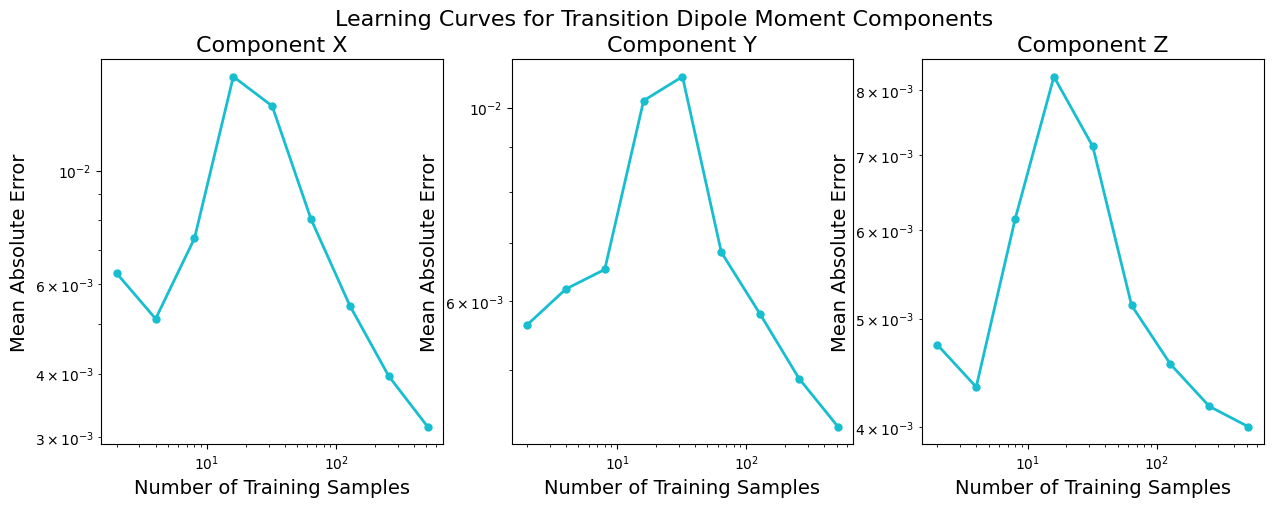

In [9]:
#Learning curve for the benzene dataset using KRR, based on the QML library
learning_curve_plots(krr_qml,"768_benzene")

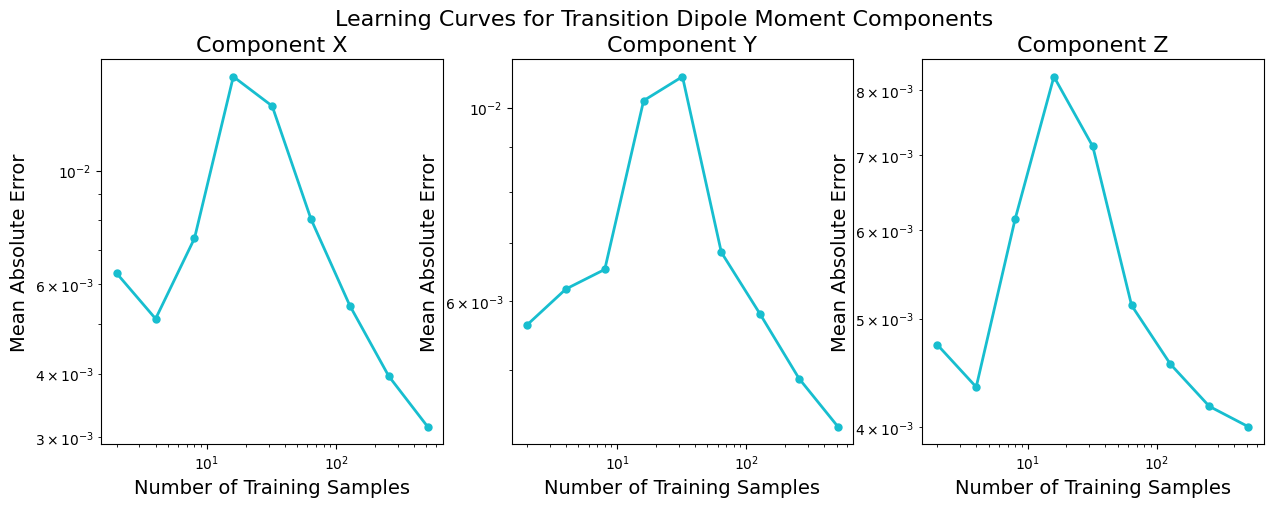

In [10]:
#Learning curve for the benzene dataset using KRR, based on the scikit-learn library
learning_curve_plots(krr_sklearn,"768_benzene")

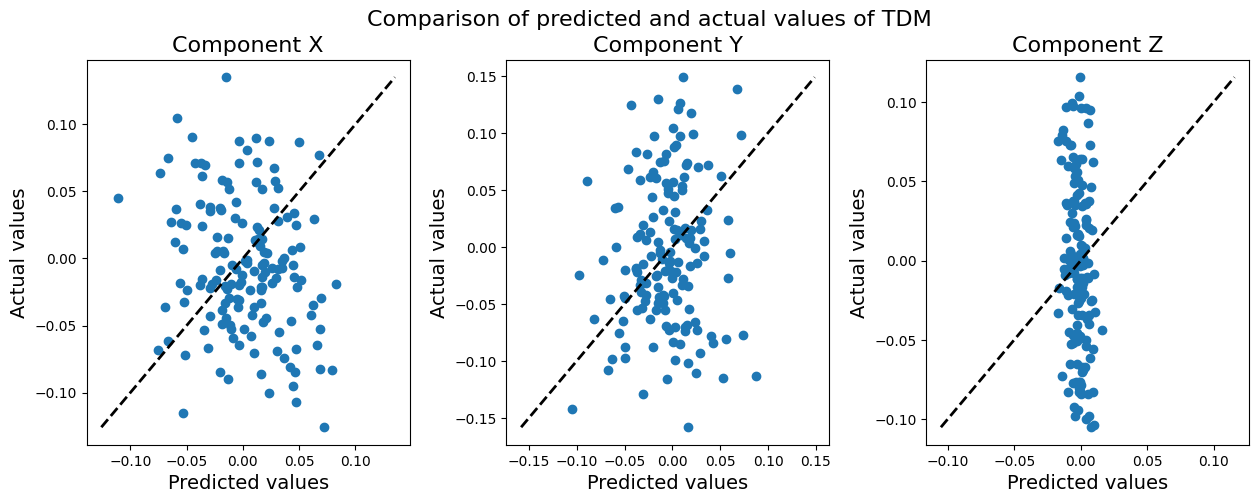

In [11]:
#Scatter plot for the benzene dataset using KRR, based on the QML library
scatter_plot("768_benzene")

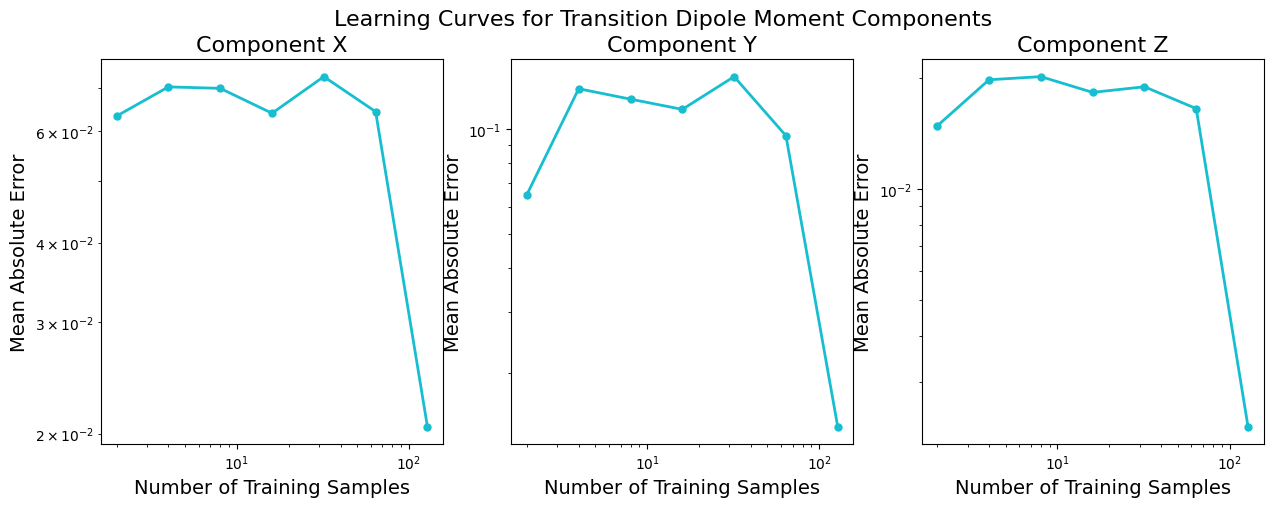

In [12]:
#Learning curve for the porphyrin dataset using KRR, based on the QML library
learning_curve_plots(krr_qml,"151_por")

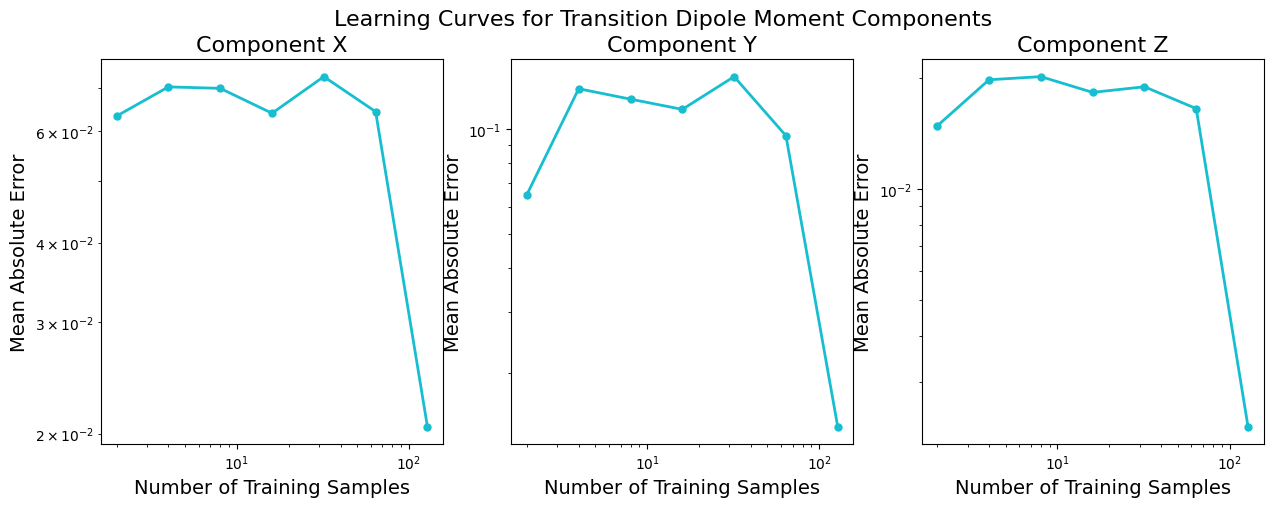

In [13]:
#Learning curve for the porphyrin dataset using KRR, based on the scikit-learn library
learning_curve_plots(krr_sklearn,"151_por")

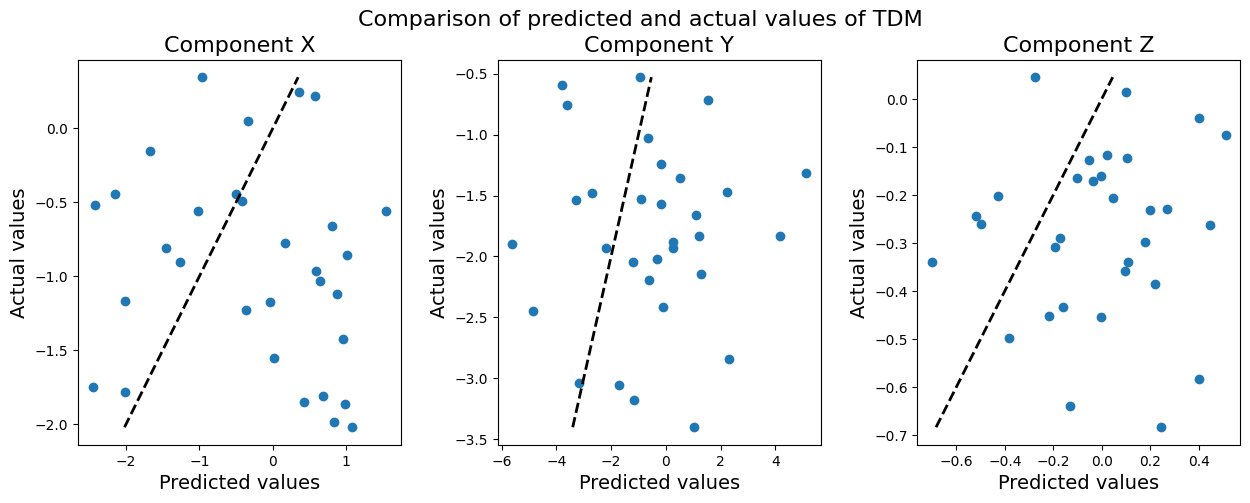

In [14]:
#Scatter plot for the porphyrin dataset using KRR, based on the QML library
scatter_plot("151_por")